In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import torch                                             # PyTorch - machine learning framework
import torch.nn as nn                                    # neural network
import torch.optim as optim
import matplotlib.pyplot as plt   
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
class Time_Series_Dataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.outputs[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(LSTM, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.num_layers = len(hidden_sizes)

        # LSTM layers
        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_sizes[0], batch_first=True, bidirectional=False))

        for i in range(1, self.num_layers):
            self.lstms.append(nn.LSTM(hidden_sizes[i-1], hidden_sizes[i], batch_first=True, bidirectional=False))
        
        self.fc1 = nn.Linear(hidden_sizes[-1], output_size)  # Fully connected layer

    def forward(self, x):
        h = x
        for lstm in self.lstms:
            out, _ = lstm(h)
            h = out
        out = self.fc1(out[:, -1, :])  # Take the output of the last time step
        return out

# LSTM Model for Quantile Multi-Step Ahead Prediction
class QuantileLSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_steps, quantiles):
        super(QuantileLSTM, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.num_layers = len(hidden_sizes)
        self.num_steps = num_steps
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)

        # LSTM layers
        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_sizes[0], batch_first=True, bidirectional=False))

        for i in range(1, self.num_layers):
            self.lstms.append(nn.LSTM(hidden_sizes[i-1], hidden_sizes[i], batch_first=True, bidirectional=False))
        
        # Fully connected layer to output num_steps * num_quantiles values
        self.fc1 = nn.Linear(hidden_sizes[-1], num_steps * self.num_quantiles)

    def forward(self, x):
        h = x
        for lstm in self.lstms:
            out, _ = lstm(h)
            h = out
        out = self.fc1(out[:, -1, :])  # Take the output of the last time step
        out = out.view(-1, self.num_steps, self.num_quantiles)  # Reshape output to (batch_size, num_steps, num_quantiles)
        return out

# Define Functions
def split_series(series, input_size, output_size, train_ratio, seed):
    # 1. split univariate series to input (X) and output (y)
    X, y = [], []  
    for i in range(len(series) - input_size - output_size + 1):
        X.append(series[i:i + input_size])                            # X = input e.g. [10, 20, 30]
        y.append(series[i + input_size:i + input_size + output_size]) # y = output e.g. [40, 50]
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

# Quantile loss function
def quantile_loss(preds, target, quantiles):
    losses = []
    for i, quantile in enumerate(quantiles):
        errors = targets[:, :, i] - preds[:, :, i]
        losses.append(torch.mean(torch.max((quantile - 1) * errors, quantile * errors)))
    return torch.mean(torch.stack(losses))

def evaluate_model(model, test_dataloader, quantiles):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in test_dataloader:
            inputs = inputs.unsqueeze(-1)  # Adjust dimensions if necessary
            targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles))  # Reshape targets
            outputs = model(inputs)  # Forward pass
            all_preds.append(outputs)
            all_targets.append(targets)
    
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    return all_preds, all_targets

pm = "\u00B1"

In [3]:
## Dataset: ETHEREUM
## Best Performing Model: LSTM - Classic Version
Ethereum = pd.read_csv('data/coin_Ethereum.csv')
Close_Price = Ethereum.iloc[:, 7].copy()
Close_Price_reshaped = np.array(Close_Price).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
Close_Price_scaled = scaler.fit_transform(Close_Price_reshaped).flatten()

# Define our parameters
input_size = 6        # 6 steps input
output_size = 5       # 5 steps output (defined as such allows us to compare our results with related work)
train_ratio = 0.8
seed = 5925
num_experiments = 30 # default: 30 (lower the number for quicker runtime)

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [4]:
for exp in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(Close_Price_scaled, input_size, output_size, train_ratio, seed)
    train_dataset = Time_Series_Dataset(X_train, y_train)
    test_dataset = Time_Series_Dataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 
    
    # Hyperparameters
    input = 1  # univariate
    hidden_sizes = [100, 100]
    model = LSTM(input, hidden_sizes, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001) # related work (MSE & ADAM = 0.001)
    
    # Training loop
    num_epochs = 100 # default: 100 (lower this number for quicker runtime)
    for epoch in range(1, num_epochs + 1):
        model.train()
        for inputs, targets in train_dataloader:
            inputs = inputs.unsqueeze(-1)  # Add feature dimension
            targets = targets
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # if epoch == 1 or epoch % 10 == 0:
            # print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

    # Evaluate the model on the test set
    model.eval()
    y_pred = []
    y_test = []
    
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs = inputs.unsqueeze(-1)
            targets = targets
            outputs = model(inputs)
            y_pred.append(outputs.numpy())
            y_test.append(targets.numpy())
    
    # Convert lists to numpy arrays
    y_pred = np.concatenate(y_pred, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(y_pred[step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Experiment {exp+1}/{num_experiments} done")
    seed += 1

print(f"Univariate LSTM Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )

Experiment 1/30 done
Experiment 2/30 done
Experiment 3/30 done
Experiment 4/30 done
Experiment 5/30 done
Experiment 6/30 done
Experiment 7/30 done
Experiment 8/30 done
Experiment 9/30 done
Experiment 10/30 done
Experiment 11/30 done
Experiment 12/30 done
Experiment 13/30 done
Experiment 14/30 done
Experiment 15/30 done
Experiment 16/30 done
Experiment 17/30 done
Experiment 18/30 done
Experiment 19/30 done
Experiment 20/30 done
Experiment 21/30 done
Experiment 22/30 done
Experiment 23/30 done
Experiment 24/30 done
Experiment 25/30 done
Experiment 26/30 done
Experiment 27/30 done
Experiment 28/30 done
Experiment 29/30 done
Experiment 30/30 done
Univariate LSTM Regression: After 30 experimental runs, here are the results:
Across 5 predictive time steps, Avg RMSE: 0.0248 ± 0.0034, Avg MAE: 44.23 ± 6.10, Avg MAPE: 152.698% ± 118.591%
At time step 1, Avg RMSE: 0.0084 ± 0.0095, Avg MAE: 35.80 ± 6.02, Avg MAPE: 166.859% ± 133.174%
At time step 2, Avg RMSE: 0.0112 ± 0.0139, Avg MAE: 40.73 ± 6.0

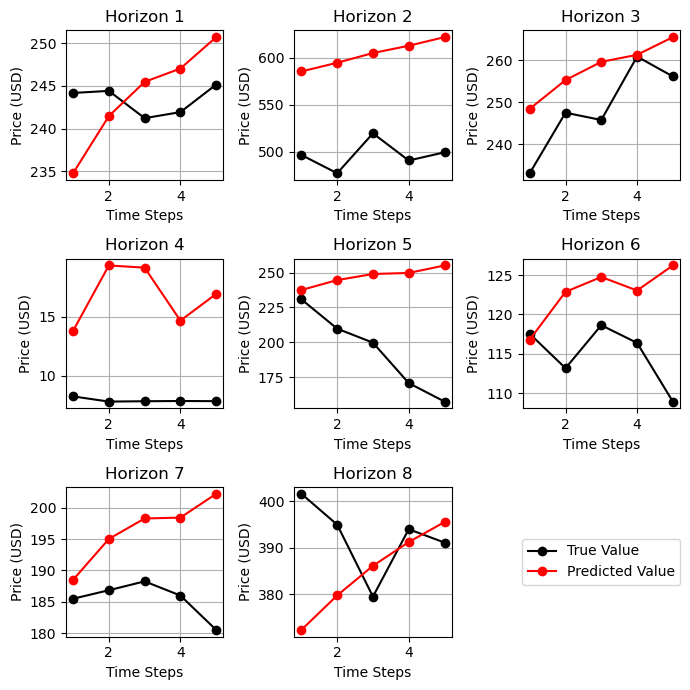

In [5]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(7, 7))  # Adjusted figure size for better spacing
axs = axs.flatten()
for i in range(8):  # Only plot the first 8 graphs
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=[axs[0].lines[0], axs[0].lines[1]], loc='center')  # Center the legend

# Adjust layout
plt.tight_layout()
plt.show()

In [6]:
## Quantile Version
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 30    # default: 30 (change to lower value for less intensive runs)


rmse, mae, mape = [], [], []
rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = [], [], [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [ ]:
for exp in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(Close_Price_scaled, input_size, output_size, train_ratio, seed)
    train_dataset = Time_Series_Dataset(X_train, y_train)
    test_dataset = Time_Series_Dataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

    # Hyperparameters
    input = 1  # univariate
    hidden_sizes = [100, 100]
    num_steps = 5  # number of steps to predict ahead
    model = QuantileLSTM(input, hidden_sizes, num_steps, quantiles)
    # Loss and optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # Training loop
    num_epochs = 100 # default: 100 
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
            
            inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
            targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
            
            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
            loss = quantile_loss(outputs, targets, quantiles)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
        
        # Print epoch information for the first epoch and every 10th epoch thereafter
        # if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
            # print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

    predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
    predicted_values = predicted_values.numpy()
    actuals = actual_values.numpy()[:, :, 0]

    pred_005 = predicted_values[:, :, 0]
    pred_025 = predicted_values[:, :, 1]
    pred_050 = predicted_values[:, :, 2]
    pred_075 = predicted_values[:, :, 3]
    pred_095 = predicted_values[:, :, 4]
    
    ## Calculate RMSE here
    mse_005 = mean_squared_error(pred_005, actuals)
    mse_025 = mean_squared_error(pred_025, actuals)
    mse_050 = mean_squared_error(pred_050, actuals)
    mse_075 = mean_squared_error(pred_075, actuals)
    mse_095 = mean_squared_error(pred_095, actuals)

    rmse_005.append(np.sqrt(mse_005))
    rmse_025.append(np.sqrt(mse_025))
    rmse_050.append(np.sqrt(mse_050))
    rmse_075.append(np.sqrt(mse_075))
    rmse_095.append(np.sqrt(mse_095))

    pred_values = predicted_values.reshape(-1, 1)
    pred_values = scaler.inverse_transform(pred_values)
    pred_values = pred_values.reshape(predicted_values.shape)
    actual_values = scaler.inverse_transform(actuals)
    
    predicted_005 = pred_values[:, :, 0]
    predicted_025 = pred_values[:, :, 1]
    predicted_050 = pred_values[:, :, 2]
    predicted_075 = pred_values[:, :, 3]
    predicted_095 = pred_values[:, :, 4]

    mae.append(mean_absolute_error(actual_values, predicted_050))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_050))

    for step in range(output_size):
        mse_step = mean_squared_error(pred_050[: , step], actuals[:, step])
        rmse_steps[step].append(np.sqrt(mse_step))
        mae_steps[step].append(mean_absolute_error(predicted_050[: , step], actual_values[:, step]))
        mape_steps[step].append(mean_absolute_percentage_error(predicted_050[: , step], actual_values[:, step]))
        
    print(f"Experiment {exp+1}/{num_experiments} done")
    
    seed += 1

print(f'BD-LSTM Average RMSE across {output_size} time steps at different quantiles:')
print(f'Quantile 0.05: {np.mean(rmse_005):.6f} {pm} {np.std(rmse_005):.6f}')
print(f'Quantile 0.25: {np.mean(rmse_025):.6f} {pm} {np.std(rmse_025):.6f}')
print(f'Quantile 0.50: {np.mean(rmse_050):.6f} {pm} {np.std(rmse_050):.6f}')
print(f'Quantile 0.75: {np.mean(rmse_075):.6f} {pm} {np.std(rmse_075):.6f}')
print(f'Quantile 0.95: {np.mean(rmse_095):.6f} {pm} {np.std(rmse_095):.6f}')

print("--------------------------------------------")

print(f"Univariate Quantile Regression Average Performance: RMSE: {np.mean(rmse_050):.4f} {pm} {np.std(rmse_050):.4f}, MAE: {np.mean(mae):.4f} {pm} {np.std(mae):.4f}, MAPE: {np.mean(mape)*100:.4f}% {pm} {np.std(mape)*100:.4f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, predictions have RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, MAE: {np.mean(mae_steps[step]):.4f} {pm} {np.std(mae_steps[step]):.4f} and MAPE: {np.mean(mape_steps[step])*100:.4f}% {pm} {np.std(mape_steps[step])*100:.4f}%")



Experiment 1/30 done
Experiment 2/30 done
Experiment 3/30 done
Experiment 4/30 done
Experiment 5/30 done
Experiment 6/30 done
Experiment 7/30 done
Experiment 8/30 done
Experiment 9/30 done
Experiment 10/30 done
Experiment 11/30 done
Experiment 12/30 done
Experiment 13/30 done
Experiment 14/30 done
Experiment 15/30 done
Experiment 16/30 done
Experiment 17/30 done
Experiment 18/30 done
Experiment 19/30 done
Experiment 20/30 done
Experiment 21/30 done
Experiment 22/30 done


In [ ]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()
plt.show()

In [ ]:
## Second best performing model: BD-LSTM (Classic version)
class BDLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BDLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_sizes[0], batch_first=True, bidirectional=True))

        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_sizes[i-1]*2, hidden_sizes[i], batch_first=True, bidirectional=True))
        
        self.fc = nn.Linear(hidden_sizes[-1] * 2, output_size)  # * 2 because of bidirectional

    def forward(self, x):
        h = x
        for lstm in self.lstms:
            out, _ = lstm(h)
            h = out
        out = self.fc(out[:, -1, :])
        return out

class BDLSTM_Quantile(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_quantiles, num_steps_ahead):
        super(BDLSTM_Quantile, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_quantiles = num_quantiles
        self.num_steps_ahead = num_steps_ahead

        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_size[0], batch_first=True, bidirectional=True))
        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_size[i-1] * 2, hidden_size[i], batch_first=True, bidirectional=True))
        
        # Define separate linear layers for each quantile
        self.fc = nn.ModuleList([nn.Linear(hidden_size[-1] * 2, self.num_steps_ahead) for _ in range(num_quantiles)])

    def forward(self, x):
        for lstm in self.lstms:
            x, _ = lstm(x)
        
        lstm_out = x[:, -1, :]  # Use the output of the last time step
        
        # Compute the outputs for each quantile
        quantile_outputs = [fc(lstm_out) for fc in self.fc]
        
        # Stack the quantile outputs
        output = torch.stack(quantile_outputs, dim=2)
        return output

In [ ]:
# Define our parameters
input_size = 6        # 6 steps input
output_size = 5       # 5 steps output (defined as such allows us to compare our results with related work)
train_ratio = 0.8
seed = 5925
num_experiments = 30 # default: 30 (lower the number for quicker runtime)

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [ ]:
for exp in range(num_experiments):
    # scaling the data makes all the difference (loss: 0.0001 vs 239499328)
    X_train, X_test, y_train, y_test = split_series(Close_Price_scaled, input_size, output_size, train_ratio, seed)
    train_dataset = Time_Series_Dataset(X_train, y_train)
    test_dataset = Time_Series_Dataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 
    # Hyperparameters
    input = 1  # Univariate time series
    hidden_sizes = [64, 32]
    num_layers = len(hidden_sizes)
    model = BDLSTM(input, hidden_sizes, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001) # related work (MSE & ADAM = 0.001)
    
    # Training loop
    num_epochs = 100 # default: 100 (lower this number for quicker runtime)
    for epoch in range(1, num_epochs + 1):
        model.train()
        for inputs, targets in train_dataloader:
            inputs = inputs.unsqueeze(-1)  # Add feature dimension
            targets = targets
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # if epoch == 1 or epoch % 10 == 0:
            # print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

    # Evaluate the model on the test set
    model.eval()
    y_pred = []
    y_test = []
    
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs = inputs.unsqueeze(-1)
            targets = targets
            outputs = model(inputs)
            y_pred.append(outputs.numpy())
            y_test.append(targets.numpy())
    
    # Convert lists to numpy arrays
    y_pred = np.concatenate(y_pred, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(y_pred[step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Experiment {exp+1}/{num_experiments} done")
    seed += 1

print(f"Univariate BD-LSTM Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )

In [ ]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(7, 7))  # Adjusted figure size for better spacing
axs = axs.flatten()
for i in range(8):  # Only plot the first 8 graphs
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=[axs[0].lines[0], axs[0].lines[1]], loc='center')  # Center the legend

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
## Quantile Version
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 30    # default: 30 (change to lower value for less intensive runs)

rmse, mae, mape = [], [], []
rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = [], [], [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [ ]:
for exp in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(Close_Price_scaled, input_size, output_size, train_ratio, seed)
    train_dataset = Time_Series_Dataset(X_train, y_train)
    test_dataset = Time_Series_Dataset(X_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

    # Hyperparameters
    input = 1  # Univariate time series, hence input_size is 1
    hidden_size = [64, 32]
    num_layers = 2
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    num_quantiles = len(quantiles)  # Number of quantiles to predict
    output_size = 5
    
    # Create the model
    model = BDLSTM_Quantile(input, hidden_size, num_layers, num_quantiles, output_size)

    # Loss and optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # Training loop
    num_epochs = 100 # default: 100 
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
            
            inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
            targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
            
            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
            loss = quantile_loss(outputs, targets, quantiles)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
        
        # Print epoch information for the first epoch and every 10th epoch thereafter
        # if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
            # print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

    predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
    predicted_values = predicted_values.numpy()
    actuals = actual_values.numpy()[:, :, 0]

    pred_005 = predicted_values[:, :, 0]
    pred_025 = predicted_values[:, :, 1]
    pred_050 = predicted_values[:, :, 2]
    pred_075 = predicted_values[:, :, 3]
    pred_095 = predicted_values[:, :, 4]
    
    ## Calculate RMSE here
    mse_005 = mean_squared_error(pred_005, actuals)
    mse_025 = mean_squared_error(pred_025, actuals)
    mse_050 = mean_squared_error(pred_050, actuals)
    mse_075 = mean_squared_error(pred_075, actuals)
    mse_095 = mean_squared_error(pred_095, actuals)

    rmse_005.append(np.sqrt(mse_005))
    rmse_025.append(np.sqrt(mse_025))
    rmse_050.append(np.sqrt(mse_050))
    rmse_075.append(np.sqrt(mse_075))
    rmse_095.append(np.sqrt(mse_095))

    pred_values = predicted_values.reshape(-1, 1)
    pred_values = scaler.inverse_transform(pred_values)
    pred_values = pred_values.reshape(predicted_values.shape)
    actual_values = scaler.inverse_transform(actuals)
    
    predicted_005 = pred_values[:, :, 0]
    predicted_025 = pred_values[:, :, 1]
    predicted_050 = pred_values[:, :, 2]
    predicted_075 = pred_values[:, :, 3]
    predicted_095 = pred_values[:, :, 4]

    mae.append(mean_absolute_error(actual_values, predicted_050))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_050))

    for step in range(output_size):
        mse_step = mean_squared_error(pred_050[: , step], actuals[:, step])
        rmse_steps[step].append(np.sqrt(mse_step))
        mae_steps[step].append(mean_absolute_error(predicted_050[: , step], actual_values[:, step]))
        mape_steps[step].append(mean_absolute_percentage_error(predicted_050[: , step], actual_values[:, step]))
        
    print(f"Experiment {exp+1}/{num_experiments} done")
    
    seed += 1

print(f'BD-LSTM Average RMSE across {output_size} time steps at different quantiles:')
print(f'Quantile 0.05: {np.mean(rmse_005):.6f} {pm} {np.std(rmse_005):.6f}')
print(f'Quantile 0.25: {np.mean(rmse_025):.6f} {pm} {np.std(rmse_025):.6f}')
print(f'Quantile 0.50: {np.mean(rmse_050):.6f} {pm} {np.std(rmse_050):.6f}')
print(f'Quantile 0.75: {np.mean(rmse_075):.6f} {pm} {np.std(rmse_075):.6f}')
print(f'Quantile 0.95: {np.mean(rmse_095):.6f} {pm} {np.std(rmse_095):.6f}')

print("--------------------------------------------")

print(f"Univariate Quantile Regression Average Performance: RMSE: {np.mean(rmse_050):.4f} {pm} {np.std(rmse_050):.4f}, MAE: {np.mean(mae):.4f} {pm} {np.std(mae):.4f}, MAPE: {np.mean(mape)*100:.4f}% {pm} {np.std(mape)*100:.4f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, predictions have RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, MAE: {np.mean(mae_steps[step]):.4f} {pm} {np.std(mae_steps[step]):.4f} and MAPE: {np.mean(mape_steps[step])*100:.4f}% {pm} {np.std(mape_steps[step])*100:.4f}%")



In [ ]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()
plt.show()